In [1]:
%load_ext autoreload
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot
import re

from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
%autoreload 2
import sys 
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from ttgenv.Utils.genParentage import maxHistoryPDGID

In [4]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=False):
        # In the initializer, any of the outputs you would like to produce are defined (ex. histograms)
        # Coffea histograms are defined in the same way as in the previous exercise
        # define a list of axes first
        
        dataset_axis = hist.Cat("dataset","Dataset")

        #Declare axis 
        #m3_axis = hist.Bin("M3", r"$M_3$ [GeV]", 40, 0., 1000)
        mass_axis = hist.Bin("mass", r"$m_{\ell\gamma}$ [GeV]", 40, -10., 10)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 40, 0., 400)
        eta_axis = hist.Bin("eta", r"$\eta_{\gamma}$", 50, -2.5, 2.5)
        #chIso_axis = hist.Bin("chIso", r"Charged Hadron Isolation", np.arange(-0.1,20.001,.05))
        
        relIso_axis=hist.Bin("relIso", "relIso", 50,-4.5,4.5)
        phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        
        
        #Define the accumulator object, a dictionary storing all of the histograms and counters 
        #that we will fill later in the process function
        self.isMC = isMC

        self._accumulator = processor.dict_accumulator({
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, phi_axis),
            'photon_mass_hist': hist.Hist("Counts", dataset_axis, mass_axis),
            
            'tight_photon_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            'tight_photon_eta': hist.Hist("Counts", dataset_axis, eta_axis),
            'tight_photon_phi': hist.Hist("Counts", dataset_axis, phi_axis),
            'tight_photon_mass': hist.Hist("Counts", dataset_axis, mass_axis),
        
            'photon_pt':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_eta':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_phi':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'label':processor.column_accumulator(np.ndarray(shape=(1,1))),

            'charge':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'cleanmask':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'cutBased':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'cutBased17Bitmap':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'eCorr':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'electronIdx':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'electronIdxG':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'electronVeto':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'energyErr':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'genPartFlav':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'genPartIdx':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'genPartIdxG':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'hoe':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'isScEtaEB':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'isScEtaEE':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jetIdx':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jetIdxG':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mass':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID17':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID17_WP80':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID17_WP90':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID_WP80':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'mvaID_WP90':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'pdgId':processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'pfRelIso03_all':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'pfRelIso03_chg':processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'pixelSeed':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'r9':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'seedGain':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'sieie':processor.column_accumulator(np.ndarray(shape=(1,1))),
            'vidNestedWPBitmap':processor.column_accumulator(np.ndarray(shape=(1,1))),
          
            
            
            'EventCount': processor.value_accumulator(int),

        }
        )
        

    @property
    def accumulator(self):
        return self._accumulator

    

    # The process method is where the heart of the analysis is.  
    # This is where all of the selections are done and the histograms get filled 
    #  (things you did in notebook cells before will be done here instead)
    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        output = self.accumulator.identity()
        output['EventCount'] = len(events)

        dataset = events.metadata['dataset']
        
        if self.isMC:
            idx = ak.to_numpy(ak.flatten(abs(events.GenPart.pdgId)))
            par = ak.to_numpy(ak.flatten(events.GenPart.genPartIdxMother))
            num = ak.to_numpy(ak.num(events.GenPart.pdgId))        
            maxParentFlatten = maxHistoryPDGID(idx,par,num)
            events["GenPart","maxParent"] = ak.unflatten(maxParentFlatten, num)

        
        ######################
        ###OverlapREMOVAL#####
        ######################
        
        doOverlapRemoval = False
        if 'TTbar' in dataset:
            doOverlapRemoval = True
            overlapPt = 10.
            overlapEta = 5.
            overlapDR = 0.1
        if re.search("^W+[1234]jets$", dataset):
            doOverlapRemoval = True
            overlapPt = 10.
            overlapEta = 2.5
            overlapDR = 0.05


            
        if doOverlapRemoval:
            genmotherIdx = events.GenPart.genPartIdxMother
            genpdgid = events.GenPart.pdgId

            #potential overlap photons are only those passing the kinematic cuts 
            overlapPhoSelect = ((events.GenPart.pt>=overlapPt) & 
                                (abs(events.GenPart.eta) < overlapEta) & 
                                (events.GenPart.pdgId==22) & 
                                (events.GenPart.status==1) & 
                                (events.GenPart.maxParent < 37)
                               )
            overlapPhotons = events.GenPart[overlapPhoSelect] 

            #also require that photons are separate from all other gen particles
            finalGen = events.GenPart[((events.GenPart.status==1)|(events.GenPart.status==71)) & (events.GenPart.pt > 0.01) &
                                      ~((abs(events.GenPart.pdgId)==12) | (abs(events.GenPart.pdgId)==14) | (abs(events.GenPart.pdgId)==16)) &
                                      ~overlapPhoSelect]

            #calculate dR between overlap photons and nearest gen particle
            phoGen, phoGenDR = overlapPhotons.nearest(finalGen, return_metric = True)
            phoGenMask = ak.fill_none(phoGenDR > overlapDR, True)

            #the event is overlapping with the separate sample if there is an overlap photon passing the dR cut, kinematic cuts, and not coming from hadronic activity
            isOverlap = ak.any(phoGenMask, axis=-1)
            passOverlapRemoval = ~isOverlap

        else:
            passOverlapRemoval = np.ones_like(len(events))==1
        
        
        ######################
        ###Object Selection###
        ######################
        
        #Add Tight Muon Select
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        #Add Jet Select
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )

        #Add b-tagged Jet Select
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        
        #Add Electron Select
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                           (abs(electrons.eta)<2.1) &
                            electrons.cutBased>=4   
                         )
        #Add Photon Select
        photon=events.Photon
        photonSelect= ((photon.pt>20) & 
                        (abs(photon.eta) < 1.4442) &
                        (photon.isScEtaEE | photon.isScEtaEB) &
                        (photon.electronVeto) & 
                        np.invert(photon.pixelSeed) 
                       )
        photonID= photon.cutBased >=2
        #Apply Selection
        tightMuons = muons[muonSelectTight]
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        photons = photon[photonSelect]
        tightPho =photon[(photonID & photonSelect)]
        tightEle = electrons[electronSelectTight]
        
        #####################
        ###Event Selection###
        #####################
        
        #Apply trigger and add event selection 
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        one_muon=(ak.num(tightMuons)==1)
        four_jets=(ak.num(tightJets)>=4)
        btag_jet=(ak.num(tightBJets)>=1)
        zero_ele=(ak.num(tightEle)==0)
        one_photon=(ak.num(tightPho)==1)
        
        # Select events passing the trigger, with exactly one tight muon, one tight photon, no electrons,  ≥4 jets, and ≥ 1 b-tagged jets. 
        eventSelection = (trigger &
                          one_muon &
                          four_jets & 
                          btag_jet &
                          one_photon &
                          zero_ele)
        
        #E=events[eventSelection]
        leading_pho=tightPho[:,:1]
        #Photon=leading_pho[eventSelection]
        
    
        ##Fill Histograms
        
        
        output['photon_pt_hist'].fill(dataset=dataset,pt=ak.flatten(photons.pt[:,:1][eventSelection])) 
        output['photon_eta_hist'].fill(dataset=dataset,eta=ak.flatten(photons.eta[:,:1][eventSelection])) 
        output['photon_mass_hist'].fill(dataset=dataset,mass=ak.flatten(photons.mass[:,:1][eventSelection])) 
        output['photon_phi_hist'].fill(dataset=dataset,phi=ak.flatten(photons.phi[:,:1][eventSelection])) 
        
        output['tight_photon_pt'].fill(dataset=dataset,pt=ak.flatten(tightPho.pt[:,:1][eventSelection])) 
        output['tight_photon_eta'].fill(dataset=dataset,eta=ak.flatten(tightPho.eta[:,:1][eventSelection])) 
        output['tight_photon_mass'].fill(dataset=dataset,mass=ak.flatten(tightPho.mass[:,:1][eventSelection])) 
        output['tight_photon_phi'].fill(dataset=dataset,phi=ak.flatten(tightPho.phi[:,:1][eventSelection])) 
        
        #return output
        pt=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pt[:,:1][eventSelection],1,clip=True))))
        output['photon_pt']+=pt
        
        eta=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.eta[:,:1][eventSelection],1,clip=True))))
        output['photon_eta']+=eta
        
        phi=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.phi[:,:1][eventSelection],1,clip=True))))
        output['photon_phi']+=phi
          
        charge=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.charge[:,:1][eventSelection],1,clip=True))))
        output['charge']+=charge
        
        
        cleanmask=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cleanmask[:,:1][eventSelection],1,clip=True))))
        output['cleanmask']+=cleanmask

        
        cutBased=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cutBased[:,:1][eventSelection],1,clip=True))))
        output['cutBased']+=cutBased

        
        cutBased17Bitmap=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cutBased17Bitmap[:,:1][eventSelection],1,clip=True))))
        output['cutBased17Bitmap']+=cutBased17Bitmap

        
        eCorr=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.eCorr[:,:1][eventSelection],1,clip=True))))
        output['eCorr']+=eCorr
    
        
        electronIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronIdx[:,:1][eventSelection],1,clip=True))))
        output['electronIdx']+=electronIdx

        
        electronIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronIdxG[:,:1][eventSelection],1,clip=True))))
        output['electronIdxG']+=electronIdxG

        
        electronVeto=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronVeto[:,:1][eventSelection],1,clip=True))))
        output['electronVeto']+=electronVeto

        
        energyErr=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.energyErr[:,:1][eventSelection],1,clip=True))))
        output['energyErr']+=energyErr

        if self.isMC:
            
            genPartFlav=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartFlav[:,:1][eventSelection],1,clip=True))))
            output['genPartFlav']+=genPartFlav

        
            genPartIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartIdx[:,:1][eventSelection],1,clip=True))))
            output['genPartIdx']+=genPartIdx

        
            genPartIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartIdxG[:,:1][eventSelection],1,clip=True))))
            output['genPartIdxG']+=genPartIdxG

        
        hoe=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.hoe[:,:1][eventSelection],1,clip=True))))
        output['hoe']+=hoe

        
        isScEtaEB=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.isScEtaEB[:,:1][eventSelection],1,clip=True))))
        output['isScEtaEB']+=isScEtaEB

        
        isScEtaEE=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.isScEtaEE[:,:1][eventSelection],1,clip=True))))
        output['isScEtaEE']+=isScEtaEE

        
        jetIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.jetIdx[:,:1][eventSelection],1,clip=True))))
        output['jetIdx']+=jetIdx

        
        jetIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.jetIdxG[:,:1][eventSelection],1,clip=True))))
        output['jetIdxG']+=jetIdxG

        
        mvaID=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID[:,:1][eventSelection],1,clip=True))))
        output['mvaID']+=mvaID

        
        mvaID17=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17[:,:1][eventSelection],1,clip=True))))
        output['mvaID17']+=mvaID17

        
        mvaID17_WP80=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17_WP80[:,:1][eventSelection],1,clip=True))))
        output['mvaID17_WP80']+=mvaID17_WP80

        
        mvaID17_WP90=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17_WP90[:,:1][eventSelection],1,clip=True))))
        output['mvaID17_WP90']+=mvaID17_WP90

        
        mvaID_WP80=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID_WP80[:,:1][eventSelection],1,clip=True))))
        output['mvaID_WP80']+=mvaID_WP80

        
        mvaID_WP90=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID_WP90[:,:1][eventSelection],1,clip=True))))
        output['mvaID_WP90']+=mvaID_WP90

        
        pdgId=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pdgId[:,:1][eventSelection],1,clip=True))))
        output['pdgId']+=pdgId

            
        pfRelIso03_all=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pfRelIso03_all[:,:1][eventSelection],1,clip=True))))
        output['pfRelIso03_all']+=pfRelIso03_all

        
        pfRelIso03_chg=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pfRelIso03_chg[:,:1][eventSelection],1,clip=True))))
        output['pfRelIso03_chg']+=pfRelIso03_chg
   
        pixelSeed=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pixelSeed[:,:1][eventSelection],1,clip=True))))
        output['pixelSeed']+=pixelSeed

        
        r9=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.r9[:,:1][eventSelection],1,clip=True))))
        output['r9']+=r9

        
        seedGain=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.seedGain[:,:1][eventSelection],1,clip=True))))
        output['seedGain']+=seedGain

        
        sieie=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.sieie[:,:1][eventSelection],1,clip=True))))
        output['sieie']+=sieie

        
        vidNestedWPBitmap=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.vidNestedWPBitmap[:,:1][eventSelection],1,clip=True)))) 
        output['vidNestedWPBitmap']+=vidNestedWPBitmap
        
        if dataset=='TTGamma':
            output['label']+=processor.column_accumulator(np.ones_like(ak.to_numpy(ak.pad_none(tightPho.pt[:,:1][eventSelection],1, clip=True))))
        elif dataset=='TTbar':
            output['label']+=processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.pad_none(tightPho.pt[:,:1][eventSelection],1, clip=True))))
        else:
            output['label']+=processor.column_accumulator(-1*np.ones_like(ak.to_numpy(ak.pad_none(tightPho.pt[:,:1][eventSelection],1, clip=True))))

            
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
#Define files to run over
skimDir="root://cmseos.fnal.gov//store/user/lpctop/TTGamma_FullRun2/Skims_v6-2/2016/"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_3of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_4of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_5of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_6of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_7of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_8of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_9of10.root",
                    #f"{skimDir}/TTbarPowheg_Semilept_2016_skim_10of10.root"
                   ],
           "WGamma":[f"{skimDir}/WGamma_2016_skim.root"],
           "Z+jets":[f'{skimDir}/DYjetsM50_ext2_2016_skim_1of10.root'],
           "W+3jets":[f"{skimDir}/W3jets_2016_skim.root"],
           "W+4jets":[f"{skimDir}/W4jets_2016_skim.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root", 
                         f"{skimDir}/Data_SingleMu_b_2016_skim_2of10.root"], 
              }

In [6]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(isMC=True),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
#     maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Preprocessing:   0%|          | 0/8 [00:00<?, ?file/s]

Processing:   0%|          | 0/27 [00:00<?, ?chunk/s]

In [7]:
import pandas as pd

In [8]:
df=pd.DataFrame({
    'pT' : np.array(outputMC['photon_pt'].value)[:,0],
    'eta': np.array(outputMC['photon_eta'].value)[:,0],
    'phi' : np.array(outputMC['photon_phi'].value)[:,0],
    'hoe' : np.array(outputMC['hoe'].value)[:,0],
    'r9' : np.array(outputMC['r9'].value)[:,0],
    'sieie' : np.array(outputMC['sieie'].value)[:,0],
    'pfRelIso03_all' : np.array(outputMC['pfRelIso03_all'].value)[:,0],
    'pfRelIso03_chg' : np.array(outputMC['pfRelIso03_chg'].value)[:,0],
    'signal' : np.array(outputMC['label'].value)[:,0]
})

In [9]:
df

,pT,eta,phi,hoe,r9,sieie,pfRelIso03_all,pfRelIso03_chg,signal
0,25.276596,-0.094711,2.010742,0.170410,0.876953,0.008835,0.010997,0.010997,-1.0
1,23.335785,1.427734,1.015625,0.045776,0.966309,0.009209,0.005825,0.005825,-1.0
2,22.587238,-1.225830,0.506226,0.000000,0.858887,0.008438,0.055459,0.000000,-1.0
3,83.839104,-0.287903,0.939331,0.000000,0.954102,0.008774,0.002121,0.000000,-1.0
4,30.075891,0.781860,-0.970215,0.027039,0.457031,0.008705,0.000000,0.000000,-1.0
5,51.385529,0.534302,0.505127,0.000000,0.965820,0.009331,0.000000,0.000000,-1.0
6,28.390060,0.299805,-2.523926,0.000000,0.978027,0.008957,0.012308,0.012308,-1.0
7,46.729622,-0.710938,0.964355,0.000000,0.963867,0.009171,0.025811,0.000000,-1.0
8,25.216236,-0.258545,-1.122803,0.000000,0.972656,0.008698,0.034713,0.000000,-1.0
9,40.860710,-1.317871,-0.305908,0.000000,0.941895,0.009163,0.000000,0.000000,-1.0


In [10]:
df.describe()

,pT,eta,phi,hoe,r9,sieie,pfRelIso03_all,pfRelIso03_chg,signal
count,182191.000000,182191.000000,182191.000000,182191.000000,182191.000000,182191.000000,182191.000000,182191.000000,182191.000000
mean,53.376048,0.005520,0.006073,0.010074,0.895126,0.009051,0.010901,0.000890,0.916752
std,51.318938,0.757049,1.811547,0.027861,0.130663,0.000645,0.022113,0.002769,0.288446
min,20.000051,-1.444092,-3.141602,0.000000,0.173218,0.000196,0.000000,0.000000,-1.000000
25%,26.403523,-0.603027,-1.560059,0.000000,0.892090,0.008804,0.000000,0.000000,1.000000
50%,36.393597,0.008160,0.004084,0.000000,0.954590,0.009132,0.000000,0.000000,1.000000
75%,58.197302,0.613647,1.572388,0.008484,0.965820,0.009438,0.011258,0.000000,1.000000
max,1116.671387,1.444092,3.141602,0.498047,3.041016,0.010223,0.253302,0.022314,1.000000


In [11]:
mask = (df['signal'] != -1)
data =df[mask]
data

,pT,eta,phi,hoe,r9,sieie,pfRelIso03_all,pfRelIso03_chg,signal
627,21.398567,0.492065,3.004883,0.000000,0.988281,0.009377,0.093837,0.000000,0.0
628,31.543884,-0.901001,-2.487793,0.019043,0.778809,0.009888,0.000000,0.000000,0.0
629,21.599880,-1.320557,2.539062,0.019714,0.944336,0.008911,0.027857,0.012751,0.0
630,50.974159,-1.229980,2.924316,0.008392,0.970703,0.009865,0.000000,0.000000,0.0
631,31.115274,-0.382568,-2.460449,0.000000,0.983398,0.009300,0.000000,0.000000,0.0
632,23.113337,0.806274,1.606934,0.000000,0.960449,0.009346,0.012402,0.012402,0.0
633,55.498737,-0.792847,1.720947,0.000000,0.952148,0.008827,0.028349,0.000000,0.0
634,35.406704,1.041992,3.139160,0.000000,0.964355,0.009499,0.000000,0.000000,0.0
635,33.436081,0.005975,-2.395996,0.103027,0.538086,0.009109,0.000000,0.000000,0.0
636,23.751986,0.247986,0.475708,0.000000,0.992188,0.009758,0.000000,0.000000,0.0


In [12]:
data.describe()

,pT,eta,phi,hoe,r9,sieie,pfRelIso03_all,pfRelIso03_chg,signal
count,181564.000000,181564.000000,181564.000000,181564.000000,181564.000000,181564.000000,181564.000000,181564.000000,181564.000000
mean,53.398570,0.005494,0.006121,0.010035,0.895208,0.009051,0.010891,0.000890,0.923371
std,51.351666,0.756895,1.811424,0.027712,0.130572,0.000645,0.022091,0.002768,0.266002
min,20.000051,-1.444092,-3.141602,0.000000,0.173218,0.000196,0.000000,0.000000,0.000000
25%,26.410411,-0.602936,-1.559387,0.000000,0.892578,0.008804,0.000000,0.000000,1.000000
50%,36.404100,0.008067,0.003866,0.000000,0.954590,0.009132,0.000000,0.000000,1.000000
75%,58.227579,0.613403,1.572754,0.008423,0.965820,0.009438,0.011248,0.000000,1.000000
max,1116.671387,1.444092,3.141602,0.498047,3.041016,0.010223,0.253302,0.022314,1.000000


In [13]:
data['signal'].value_counts()

1.0    167651
0.0     13913
Name: signal, dtype: int64

In [14]:
#pip install seaborn --upgrade

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
seed=10
data=data.sample(frac=1, random_state=seed)
X=data.drop(['signal'], axis=1)
Y=data.signal

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.10, random_state=seed)


In [18]:
print ("Train data set size : ", X_train.shape)
print ("Validation data set size : ", X_val.shape)

Train data set size :  (163407, 8)
Validation data set size :  (18157, 8)


In [19]:
scaler = MinMaxScaler() 
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.fit_transform(X_val)
print(X_train_scaled)

[[0.04910934 0.05181741 0.58785359 ... 0.85315866 0.00492299 0.        ]
 [0.00821885 0.76914624 0.27537302 ... 0.89500464 0.06713216 0.39446039]
 [0.00663185 0.56477177 0.73939229 ... 0.7991393  0.31429569 0.        ]
 ...
 [0.13442483 0.17180896 0.18775256 ... 0.90717801 0.         0.        ]
 [0.00815732 0.46894548 0.72711377 ... 0.86000618 0.         0.        ]
 [0.00517813 0.26001691 0.94389182 ... 0.98250077 0.10733132 0.        ]]


In [20]:
models=[]
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('BC', BaggingClassifier()))
models.append(('Ada', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))

In [21]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    m = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(m)

DT: 0.855214 (0.001647)
RF: 0.921619 (0.001415)
BC: 0.919141 (0.001444)
Ada: 0.924348 (0.001310)
GB: 0.924795 (0.001110)
XGB: 0.924795 (0.001165)


In [22]:
#XGBoost parameter hypertunning

#par={'max_depth':[3,5,6,9,10], 'learning_rate':[0.001,0.01,0.1,1], 'reg_lambda': [0.001, 0.005, 0.01, 0.1]}
#xgb=XGBClassifier(n_jobs=-1, eval_metric='mlogloss')

#xgrid=GridSearchCV(estimator=xgb, param_grid=par, scoring ='accuracy', cv = kfold)
#xgrid_results =xgrid.fit(X_train_scaled, y_train)
#print("Best: %f using %s" %(xgrid_results.best_score_, xgrid_results.best_params_))

In [23]:
xg=XGBClassifier(n_jobs=-1, eval_metric='mlogloss', learning_rate=0.1, max_depth=5, random_state=10)
xg.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       0.77      0.05      0.10     12542
         1.0       0.93      1.00      0.96    150865

    accuracy                           0.93    163407
   macro avg       0.85      0.52      0.53    163407
weighted avg       0.92      0.93      0.89    163407


Validating Classification Report:

               precision    recall  f1-score   support

         0.0       0.57      0.04      0.08      1371
         1.0       0.93      1.00      0.96     16786

    accuracy                           0.93     18157
   macro avg       0.75      0.52      0.52     18157
weighted avg       0.90      0.93      0.89     18157


Validating Confusion Matrix:



<Figure size 432x288 with 0 Axes>

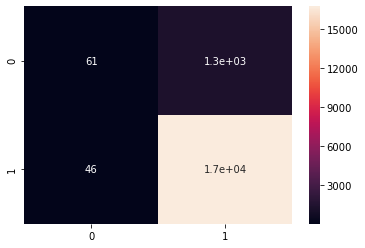

<Figure size 432x288 with 0 Axes>

In [24]:
import seaborn as sns

# predict the labels of the train set
tpred = xg.predict(X_train_scaled)
# predict the labels of the validation set
vpred = xg.predict(X_val_scaled)

#print(accuracy_score(vpred, y_val))

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(y_train, tpred))


# print quality metrics
print('\nValidating Classification Report:\n\n', classification_report(y_val, vpred))


print('\nValidating Confusion Matrix:\n')
sns.heatmap(confusion_matrix(y_val, vpred), annot=True)
plt.figure()

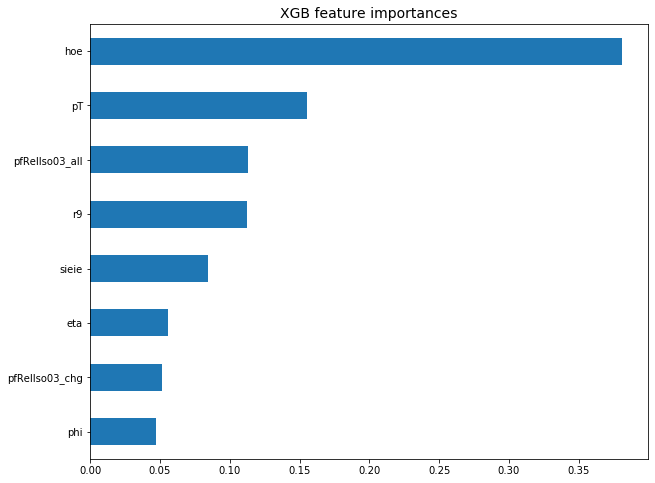

In [25]:
important = pd.Series(data=xg.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,8))
_ = important.plot(kind='barh')
_ = plt.title('XGB feature importances', fontsize=14)

In [26]:
import keras.backend as K
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input, Concatenate, Dropout
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from tensorflow.keras.regularizers import l1_l2

#from keras.losses import MeanSquaredError
import sklearn.metrics

Using TensorFlow backend.


In [50]:
N = np.shape(X_train_scaled[0])[0]

model= Sequential()
model.add(Dense(128, input_dim=N, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_44 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 9         
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
_________________________________________________________________


In [61]:
n_epochs = 40
n_batches = 100

M=model.fit(X_train_scaled, y_train,validation_data=(X_val_scaled, y_val),epochs=n_epochs, batch_size=n_batches, verbose=1)


Train on 163407 samples, validate on 18157 samples
Epoch 1/40
163407/163407 [==============================] - 3s 16us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 2/40
163407/163407 [==============================] - 3s 16us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 3/40
163407/163407 [==============================] - 3s 15us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 4/40
163407/163407 [==============================] - 2s 15us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 5/40
163407/163407 [==============================] - 2s 14us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 6/40
163407/163407 [==============================] - 2s 13us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1.2038 - val_acc: 0.9245
Epoch 7/40
163407/163407 [==============================] - 2s 13us/step - loss: 1.2236 - acc: 0.9232 - val_loss: 1

In [62]:
pred_train= model.predict(X_train_scaled)
scores = model.evaluate(X_train_scaled, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_val_scaled)
scores2 = model.evaluate(X_val_scaled, y_val, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    


Accuracy on training data: 0.923246862129894% 
 Error on training data: 0.07675313787010596
Accuracy on test data: 0.924491931486479% 
 Error on test data: 0.07550806851352099
